# Import

In [1]:

import numpy as np
import json
from scipy.sparse import load_npz,save_npz,diags,csr_matrix
import scipy.sparse as sp
import pandas as pd
import os
import requests
from io import BytesIO
from tqdm import tqdm
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from pypdf import PdfReader, PdfWriter
from tempfile import NamedTemporaryFile
import networkx as nx
import pickle
import gseapy as gp
import mygene
from IPython.display import display, HTML
import re
from collections import deque
from goatools.obo_parser import GODag
import math
from itertools import combinations
from collections import Counter
from gseapy.parser import read_gmt
import time

In [2]:
pd.set_option('display.width', None)      # No line-wrapping
pd.set_option('display.max_columns', None)  # Show all columns

# Prep

In [3]:
DISEASE = "BIPOLAR"
DISEASE_FOLDER = f"../output/{DISEASE}/"
RESULT_FOLDER = DISEASE_FOLDER + "leiden_results/"
DGIDB_DIRECTORY = f"../../Gen_Hypergraph/output/DGIDB_{DISEASE}/"

with open(DGIDB_DIRECTORY + "gene_to_index.json", "r") as file:
    gene_to_index_distinct = json.load(file)

In [36]:
len(gene_to_index_distinct)

4774

In [4]:
index_to_gene_distinct = {v: k for k, v in gene_to_index_distinct.items()}

In [5]:
# Community preprocessing
def zscore(values):
    arr = np.asarray(values, dtype=float)
    if arr.size == 0:
        return arr

    mean = arr.mean()
    std = arr.std(ddof=0)

    if std == 0 or np.isnan(std):
        # no variation: all z-scores = 0
        return np.zeros_like(arr)

    return (arr - mean) / std

def communities_cutoff(communities, cutoff = 100):
    result = []
    for community in communities:
        if len(community) >= cutoff:
            result.append(community)

    return result, len(result)

def community_central_genes_by_num(G, community_nodes, weight="weight", top_n=20):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return [u for u in ranked[:top_n]]

def community_central_genes_by_score(G, community_nodes, weight="weight",score_cap = 1):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    return [u for u in ranked if Z[u] >= score_cap]

def community_central_genes_by_pct(G, community_nodes, weight="weight",pct = 0.3):
    C = set(community_nodes)
    H = G.subgraph(C).copy()                       # induced subgraph
    # within-community (weighted) degree
    k = {u: H.degree(u, weight=weight) for u in H}
    ks = np.array(list(k.values()), dtype=float)
    zscore_list = zscore(ks)
    Z = dict(zip(H,zscore_list))        # within-module degree z-score

    # rank by z
    ranked = sorted(H.nodes(), key=lambda u: (Z[u]), reverse=True)
    top = int(len(ranked)*pct)
    return [u for u in ranked[:top]]



In [6]:
# Helpful functions
def drop_nan_from_communities(communities):
    cleaned_communities = []
    total_dropped = 0

    for i, community in enumerate(communities):
        cleaned = []
        dropped = 0
        for g in community:
            if g is None or (isinstance(g, float) and math.isnan(g)):
                dropped += 1
            else:
                cleaned.append(g)
        cleaned_communities.append(cleaned)
        total_dropped += dropped
        print(f"Community {i}: dropped {dropped} NaN entries")

    print(f"\nTotal dropped across all communities: {total_dropped}")
    return cleaned_communities

def big_objects(n=10, min_mb=1):
    """
    Show the largest objects currently in memory.
    
    Parameters
    ----------
    n : int
        Number of top objects to show.
    min_mb : float
        Minimum size (in MB) to include.
    """
    import sys
    import numpy as np
    import pandas as pd
    import scipy.sparse as sp
    from IPython import get_ipython

    def get_size(obj):
        try:
            if isinstance(obj, np.ndarray):
                return obj.nbytes
            elif isinstance(obj, pd.DataFrame) or isinstance(obj, pd.Series):
                return obj.memory_usage(deep=True).sum()
            elif sp.issparse(obj):
                return (obj.data.nbytes +
                        obj.indptr.nbytes +
                        obj.indices.nbytes)
            else:
                return sys.getsizeof(obj)
        except Exception:
            return 0

    ip = get_ipython()
    if ip is None:
        ns = globals()
    else:
        ns = ip.user_ns

    items = []
    for name, val in ns.items():
        if name.startswith('_'):
            continue  # skip internals
        size = get_size(val)
        if size > min_mb * 1024 ** 2:
            items.append((name, type(val).__name__, size))

    items.sort(key=lambda x: x[2], reverse=True)

    print(f"{'Variable':30s} {'Type':25s} {'Size (MB)':>10s}")
    print("-" * 70)
    for name, t, size in items[:n]:
        print(f"{name:30s} {t:25s} {size / 1024 ** 2:10.2f}")

In [7]:
# Z-score distribution
def compute_within_community_zscores(G, communities):
    """
    Compute within-community degree z-scores for each node.

    Parameters
    ----------
    G : networkx.Graph
        Graph whose nodes match those in `communities`.
        Uses edge weight from 'weight' attribute if present; otherwise 1.0.
    communities : list of list
        communities[c] is a list of node IDs in community c.

    Returns
    -------
    pandas.DataFrame
        Columns: ['node', 'community', 'k_in', 'zscore']
    """
    # 1. Node -> community map
    node_to_comm = {
        node: cid
        for cid, comm in enumerate(communities)
        for node in comm
    }

    # 2. Initialize within-community degree for every node
    k_in = {node: 0.0 for node in node_to_comm.keys()}

    # 3. Iterate over edges once, add weight if endpoints in same community
    for u, v, data in G.edges(data=True):
        if u not in node_to_comm or v not in node_to_comm:
            continue  # skip nodes not in any community (if that happens)

        cu = node_to_comm[u]
        cv = node_to_comm[v]

        if cu == cv:
            w = data.get("weight", 1.0)
            k_in[u] += w
            k_in[v] += w

    # 4. Build DataFrame
    rows = [
        (node, node_to_comm[node], k_val)
        for node, k_val in k_in.items()
    ]
    df = pd.DataFrame(rows, columns=["node", "community", "k_in"])

    # 5. Compute z-scores per community using the helper
    df["zscore"] = df.groupby("community")["k_in"].transform(zscore)

    return df

def plot_zscore_hist_all(df_z, bins=20, per_row=4, max_communities=None):
    communities = sorted(df_z["community"].unique())
    if max_communities is not None:
        communities = communities[:max_communities]

    n = len(communities)
    nrows = int(np.ceil(n / per_row))
    ncols = per_row

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = np.array(axes).flatten()

    for ax, cid in zip(axes, communities):
        zvals = df_z.loc[df_z["community"] == cid, "zscore"]
        ax.hist(zvals, bins=bins)
        ax.set_title(f"Community {cid}")
        ax.set_xlabel("z-score")
        ax.set_ylabel("Frequency")

    for ax in axes[len(communities):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [8]:
# Degree distribution
def compute_within_community_degrees(G, communities):
    """Compute within-community degrees for each node."""
    node_to_comm = {node: cid for cid, comm in enumerate(communities) for node in comm}
    k_in = {node: 0.0 for node in node_to_comm}

    for u, v, data in G.edges(data=True):
        if u not in node_to_comm or v not in node_to_comm:
            continue
        cu, cv = node_to_comm[u], node_to_comm[v]
        if cu == cv:
            w = data.get("weight", 1.0)
            k_in[u] += w
            k_in[v] += w

    df = pd.DataFrame([(n, node_to_comm[n], d) for n, d in k_in.items()],
                      columns=["node", "community", "k_in"])
    return df


def plot_topk_community_degree_distributions(G, communities, top_k=20, normalize=True, bins=20):
    """
    Plot within-community degree distributions for the top_k largest communities.

    Parameters
    ----------
    G : networkx.Graph
        Input graph.
    communities : list[list]
        List of node lists (each representing a community).
    top_k : int, optional
        Number of largest communities (by size) to plot. Default is 20.
    normalize : bool, optional
        If True, y-axis shows probability instead of count. Default is True.
    bins : int, optional
        Number of bins in each histogram. Default is 20.
    """
    df = compute_within_community_degrees(G, communities)

    # Select top_k largest communities by node count
    comm_sizes = df["community"].value_counts().sort_values(ascending=False)
    top_comms = comm_sizes.index[:top_k]

    # Determine subplot grid (square-ish)
    ncols = 5
    nrows = int(np.ceil(top_k / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = axes.flatten()

    for i, cid in enumerate(top_comms):
        ax = axes[i]
        vals = df.loc[df["community"] == cid, "k_in"].values
        if len(vals) == 0:
            continue

        weights = np.ones_like(vals) / len(vals) if normalize else None
        ax.hist(vals, bins=bins, weights=weights, color="steelblue", alpha=0.7)
        ax.set_title(f"Community {cid} (n={len(vals)})", fontsize=10)
        ax.set_xlabel("$k_{in}$", fontsize=9)
        ax.set_ylabel("Prob." if normalize else "Count", fontsize=9)
        ax.tick_params(axis="both", labelsize=8)

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Within-community degree distributions (Top {top_k})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

In [9]:
# Loading result graph and communities
with open(f"{RESULT_FOLDER}/result_communities_DGIDB.pkl", "rb") as f:
    communities = pickle.load(f)
with open(f"{RESULT_FOLDER}/result_graph_DGIDB.pkl", "rb") as f:
    graph = pickle.load(f)

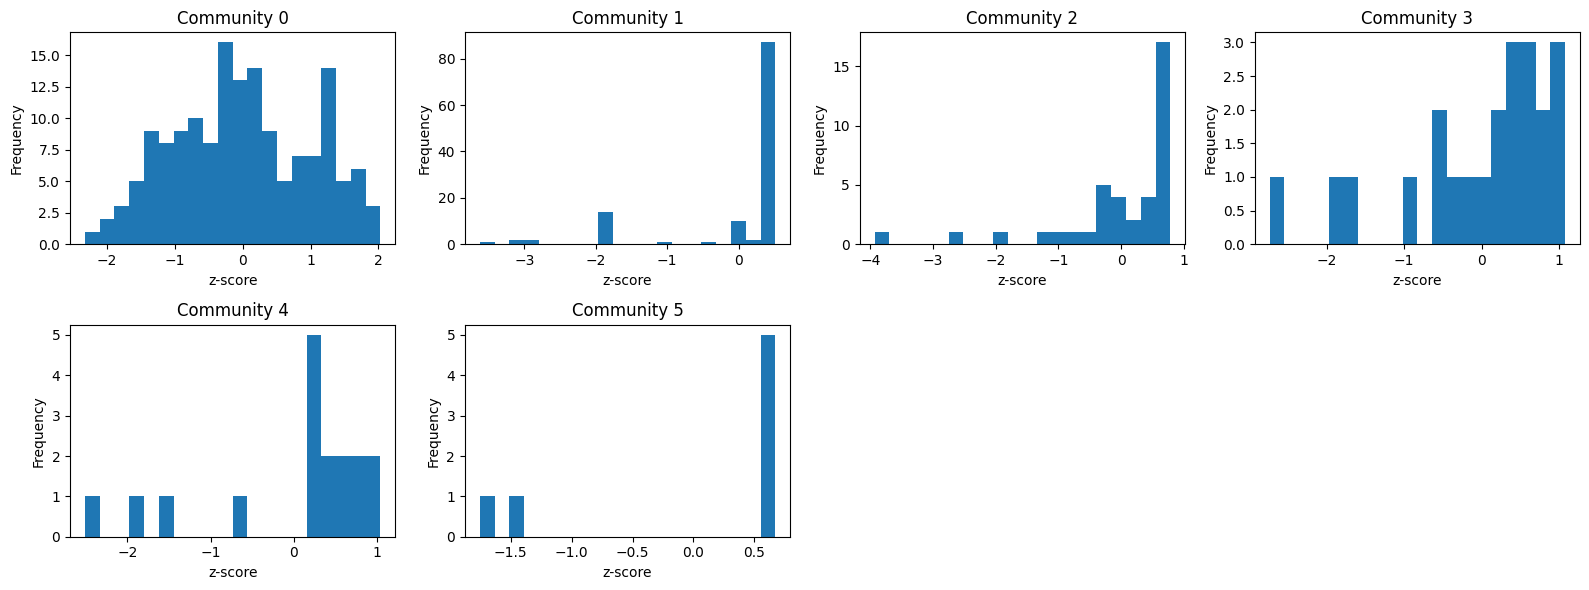

In [10]:
communities_df = compute_within_community_zscores(graph, communities)
plot_zscore_hist_all(communities_df, bins=20, per_row=4,max_communities=20)

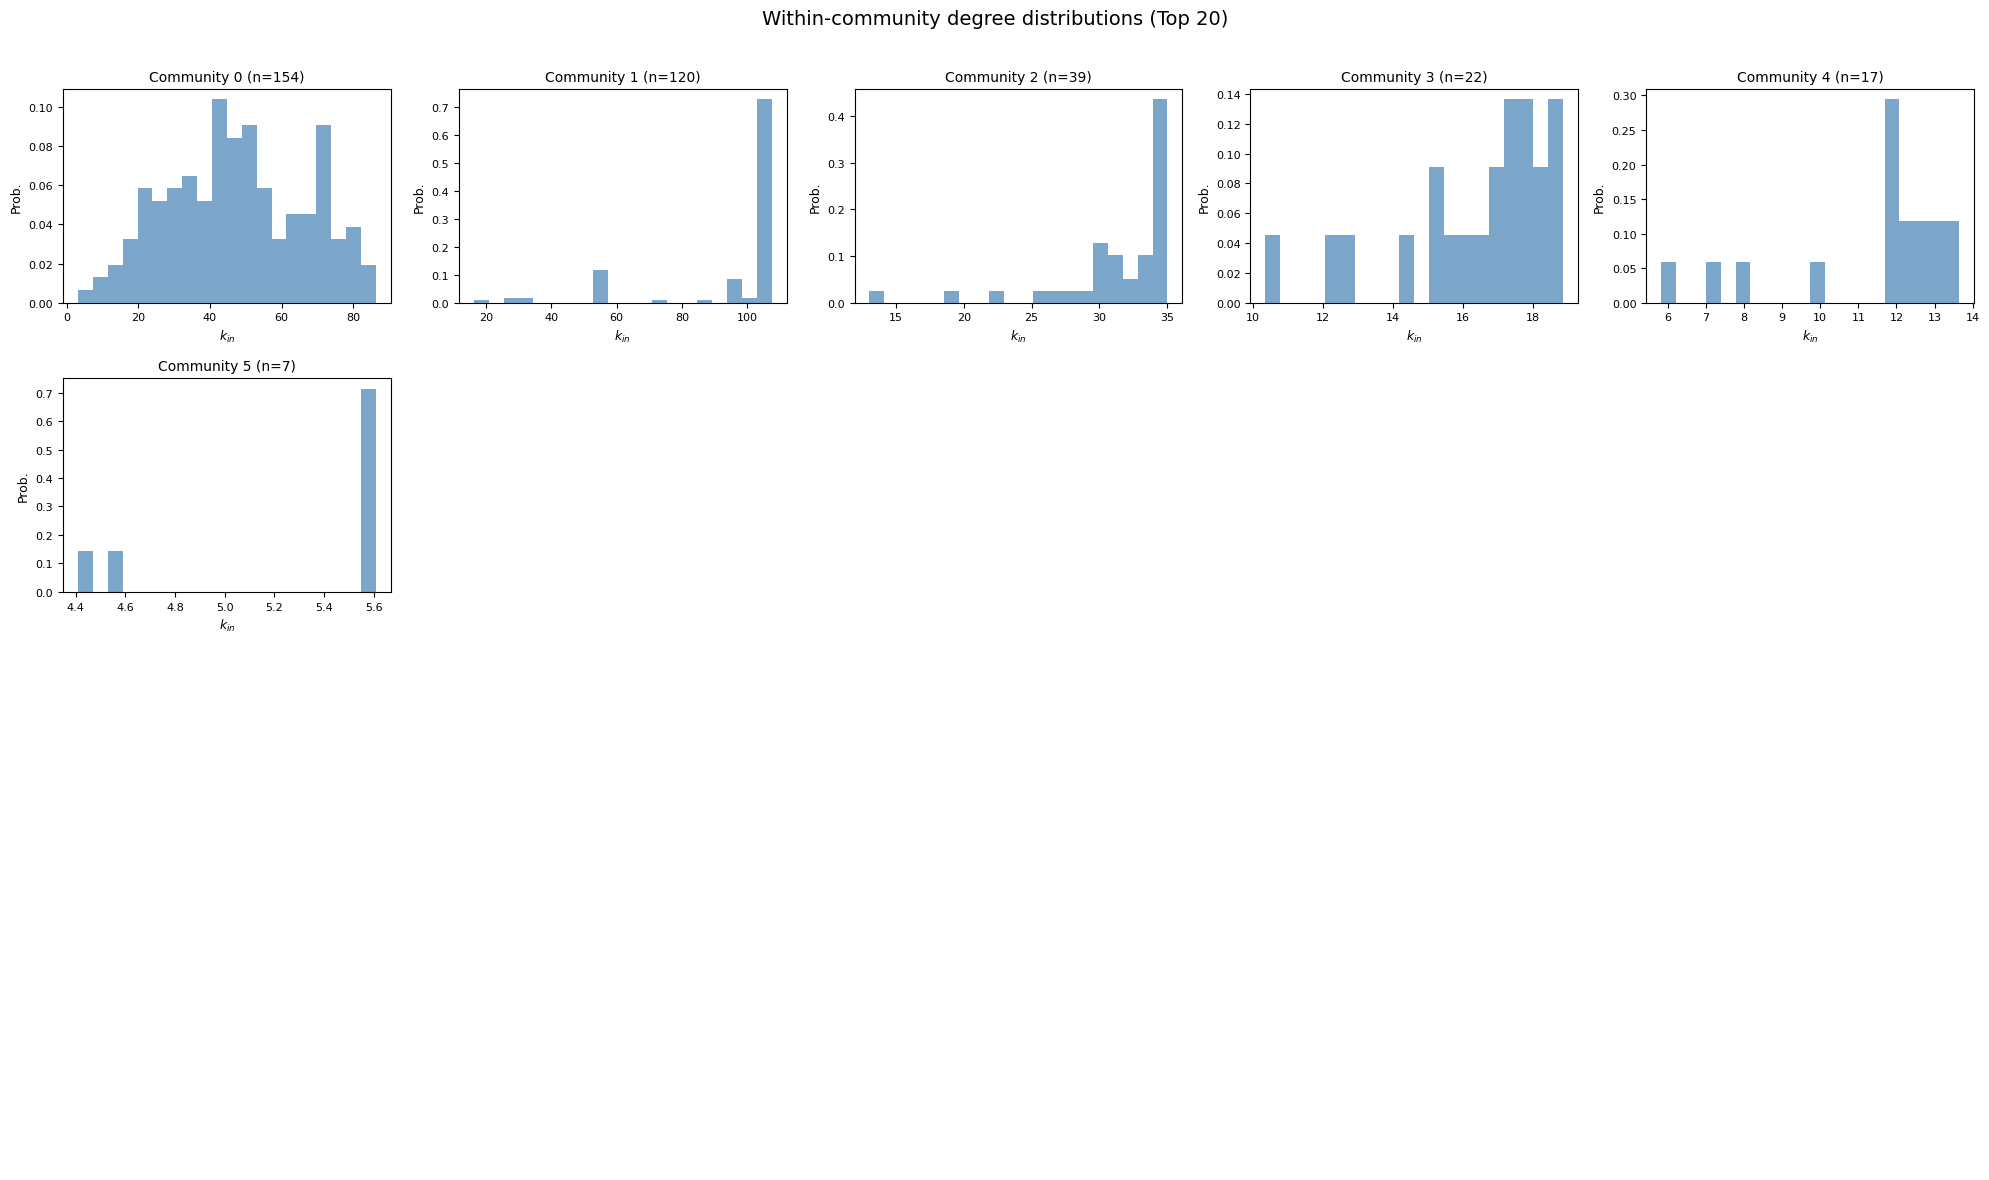

In [11]:
plot_topk_community_degree_distributions(graph, communities, top_k=20, normalize=True)

In [12]:
# Checking communities greater than 100
communities_greater_than_cutoff,num_greater_cutoff = communities_cutoff(communities,30)
print(communities_greater_than_cutoff, '\n', num_greater_cutoff)
print(len(communities))

[[1, 2, 4, 6, 7, 9, 10, 13, 16, 18, 19, 27, 29, 31, 36, 38, 43, 44, 45, 46, 48, 50, 51, 58, 59, 60, 61, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 78, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 98, 100, 103, 104, 105, 106, 107, 112, 118, 119, 122, 124, 125, 126, 131, 132, 133, 136, 138, 140, 141, 144, 145, 154, 156, 157, 158, 159, 161, 162, 163, 164, 170, 171, 172, 174, 176, 177, 181, 182, 183, 186, 188, 197, 203, 204, 206, 211, 213, 216, 220, 223, 226, 242, 244, 245, 250, 257, 260, 263, 265, 269, 273, 274, 275, 276, 278, 279, 281, 282, 288, 289, 290, 292, 295, 296, 299, 300, 304, 305, 306, 311, 312, 315, 319, 323, 326, 327, 329, 330, 331, 334, 339, 343, 344, 348, 349, 350, 353, 354, 356, 357, 358], [0, 3, 5, 8, 11, 12, 15, 17, 24, 26, 28, 32, 33, 34, 37, 40, 41, 42, 47, 49, 56, 57, 64, 67, 68, 76, 79, 82, 93, 96, 101, 102, 108, 110, 111, 113, 114, 115, 116, 117, 120, 123, 127, 128, 130, 134, 135, 137, 139, 142, 143, 148, 149, 150, 152, 153, 155, 160, 166, 167, 168, 169, 173, 175

In [ ]:
# # Update communities to include only the important genes, determined by a community-size_cap and percent_cap
# SIZE_CAP = 30
# PCT = 0.3
# communities_selected = []
# for community in communities:
#     if (len(community) >= SIZE_CAP):
#         important_nodes = community_central_genes_by_pct(graph,community,pct = PCT)
#         communities_selected.append(important_nodes)

In [13]:
communities_selected = communities

In [14]:
print(communities_selected)
print(len(communities_selected))

[[1, 2, 4, 6, 7, 9, 10, 13, 16, 18, 19, 27, 29, 31, 36, 38, 43, 44, 45, 46, 48, 50, 51, 58, 59, 60, 61, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 78, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 98, 100, 103, 104, 105, 106, 107, 112, 118, 119, 122, 124, 125, 126, 131, 132, 133, 136, 138, 140, 141, 144, 145, 154, 156, 157, 158, 159, 161, 162, 163, 164, 170, 171, 172, 174, 176, 177, 181, 182, 183, 186, 188, 197, 203, 204, 206, 211, 213, 216, 220, 223, 226, 242, 244, 245, 250, 257, 260, 263, 265, 269, 273, 274, 275, 276, 278, 279, 281, 282, 288, 289, 290, 292, 295, 296, 299, 300, 304, 305, 306, 311, 312, 315, 319, 323, 326, 327, 329, 330, 331, 334, 339, 343, 344, 348, 349, 350, 353, 354, 356, 357, 358], [0, 3, 5, 8, 11, 12, 15, 17, 24, 26, 28, 32, 33, 34, 37, 40, 41, 42, 47, 49, 56, 57, 64, 67, 68, 76, 79, 82, 93, 96, 101, 102, 108, 110, 111, 113, 114, 115, 116, 117, 120, 123, 127, 128, 130, 134, 135, 137, 139, 142, 143, 148, 149, 150, 152, 153, 155, 160, 166, 167, 168, 169, 173, 175

In [17]:
# Convert index to ncbi
communities_ncbi = [list(map(index_to_gene_distinct.get, c)) for c in communities_selected]
print(communities_ncbi)

[['5468', '79915', '5594', '3791', '142', '1838', '2159', '6351', '3725', '283106', '153', '2099', '9290', '1813', '2908', '776', '3570', '6198', '147746', '7468', '5742', '552', '3156', '2906', '1906', '354', '3952', '2648', '5893', '1395', '2568', '2357', '1080', '2185', '256815', '5604', '2740', '146850', '3480', '7015', '2237', '6607', '1576', '1504', '1232', '6555', '7450', '6300', '10376', '3265', '64979', '146', '148', '1119', '2565', '293', '333', '23385', '3693', '6648', '154', '1128', '7852', '3357', '927', '6863', '3350', '11224', '23552', '2555', '673', '4128', '1902', '5159', '20', '7190', '415', '147', '1993', '580', '367', '4233', '7301', '2628', '84617', '54567', '5683', '3674', '5566', '9963', '1132', '5728', '3615', '10021', '641', '3283', '2353', '1719', '3576', '23533', '5290', '23410', '2693', '1728', '2475', '21', '688', '4893', '2905', '2030', '116443', '29127', '1936', '724', '1133', '10951', '2176', '2070', '23411', '2563', '217', '782', '2798', '23081', '64805

In [18]:
# NCBI to HGNC symbol
COMMUNITIES_HGNC = []
missed = []


for community in communities_ncbi:
    mg = mygene.MyGeneInfo()
    entrez_ids = [str(e) for e in community]

    results = mg.querymany(
        entrez_ids,
        scopes="entrezgene",
        fields="symbol",
        species="human"
    )

    # Build a mapping: input ID -> symbol (or None)
    id_to_symbol = {}
    for r in results:
        q = str(r.get("query"))
        id_to_symbol[q] = r.get("symbol") if not r.get("notfound") else None

    # Preserve original order
    symbols = [id_to_symbol.get(str(e), None) for e in entrez_ids]
    COMMUNITIES_HGNC.append(symbols)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found no hit:	['3']
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


In [19]:
print(COMMUNITIES_HGNC)

[['PPARG', 'ATAD5', 'MAPK1', 'KDR', 'PARP1', 'DTNB', 'F10', 'CCL4', 'JUN', 'CSNK2A3', 'ADRB1', 'ESR1', 'GPR55', 'DRD2', 'NR3C1', 'CACNA1D', 'IL6R', 'RPS6KB1', 'HIPK4', 'NSD2', 'PTGS1', 'AVPR1A', 'HMGCR', 'GRIN2D', 'EDN1', 'KLK3', 'LEP', 'KAT2A', 'RAD52', 'CRHR2', 'GABRP', 'FPR1', 'CFTR', 'PTK2B', 'C10orf67', 'MAP2K1', 'GLP1R', 'PIK3R6', 'IGF1R', 'TERT', 'FEN1', 'SMN2', 'CYP3A4', 'CTRB1', 'CCR3', 'SLC10A2', 'VWF', 'MAPK12', 'TUBA1B', 'HRAS', 'MRPL36', 'ADRA1D', 'ADRA1A', 'CHKA', 'GABRG1', 'SLC25A6', 'APLP1', 'NCSTN', 'ITGB5', 'SOD2', 'ADRB2', 'CHRM1', 'CXCR4', 'HTR2B', 'CD8B2', 'TAC1', 'HTR1A', 'RPL35', 'CDK20', 'GABRA2', 'BRAF', 'MAOA', 'LPAR1', 'PDGFRB', 'ABCA2', 'HSP90B2P', 'ARSL', 'ADRA1B', 'ELAVL2', 'BARD1', 'AR', 'MET', 'TYRO3', 'GATM', 'TUBB6', 'DLL4', 'PSMA2', 'ITGA2B', 'PRKACA', 'SLC23A1', 'CHRM4', 'PTEN', 'IMPDH2', 'HCN4', 'BLM', 'HSD3B1', 'FOS', 'DHFR', 'CXCL8', 'PIK3R5', 'PIK3CA', 'SIRT3', 'GHSR', 'NQO1', 'MTOR', 'ABCA3', 'KLF5', 'NRAS', 'GRIN2C', 'SLC29A1', 'GRIN3A', 'RACGA

In [20]:
COMMUNITIES_HGNC = drop_nan_from_communities(COMMUNITIES_HGNC)

Community 0: dropped 1 NaN entries
Community 1: dropped 0 NaN entries
Community 2: dropped 0 NaN entries
Community 3: dropped 0 NaN entries
Community 4: dropped 0 NaN entries
Community 5: dropped 0 NaN entries

Total dropped across all communities: 1


# Categoization Prep

### GO-slim

In [21]:
DATA_DIRECTORY = "../../data"
GO_OBO = f"{DATA_DIRECTORY}/GO/go-basic.obo"            # put the file in your working dir (or give full path)
GOSLIM_OBO = f"{DATA_DIRECTORY}/GO/goslim_generic.obo"  # swap to another slim if you prefer
GOSLIM_PIR_OBO = f"{DATA_DIRECTORY}/GO/goslim_pir.obo"  # swap to another slim if you prefer
GOSLIM_YEAST_OBO = f"{DATA_DIRECTORY}/GO/goslim_yeast.obo"
GOSLIM_AGR_OBO = f"{DATA_DIRECTORY}/GO/goslim_agr.obo"

In [22]:
# pip install goatools


# GO library
go = GODag(GO_OBO, optional_attrs={'relationship'})

# SLIM libraries
slim = GODag(GOSLIM_OBO)
slim_pir = GODag(GOSLIM_PIR_OBO)
slim_yeast = GODag(GOSLIM_YEAST_OBO)
slim_agr = GODag(GOSLIM_AGR_OBO)

slim_ids = set(slim.keys())
slim_pir_ids = set(slim_pir.keys())
slim_yeast_ids = set(slim_yeast.keys())
slim_agr_ids = set(slim_agr.keys())


slim_names = {sid: slim[sid].name for sid in slim_ids}

../../data/GO/go-basic.obo: fmt(1.2) rel(2025-10-10) 42,666 Terms; optional_attrs(relationship)
../../data/GO/goslim_generic.obo: fmt(1.2) rel(go/2025-10-10/subsets/goslim_generic.owl) 205 Terms
../../data/GO/goslim_pir.obo: fmt(1.2) rel(go/2025-10-10/subsets/goslim_pir.owl) 617 Terms
../../data/GO/goslim_yeast.obo: fmt(1.2) rel(go/2025-10-10/subsets/goslim_yeast.owl) 295 Terms
../../data/GO/goslim_agr.obo: fmt(1.2) rel(go/2025-10-10/subsets/goslim_agr.owl) 94 Terms


In [23]:
GO_RE = re.compile(r"(GO:\d{7})")

def get_goid(term: str):
    if isinstance(term, str):
        m = GO_RE.search(term)
        if m:
            return m.group(1)
    return None

def map_to_goslim(go_id,slim_ids_param):
    """Return all GO-Slim IDs that are ancestors (or self) of the GO term."""
    if not go_id or go_id not in go:
        return []
    node = go[go_id]
    parents = node.get_all_parents()
    if parents and not isinstance(next(iter(parents)), str):
        anc_ids = {node.id} | {t.id for t in parents}
    else:
        anc_ids = {node.id} | set(parents)
    return sorted(anc_ids & slim_ids_param)

In [24]:
from collections import deque

def get_go_ancestors_at_depth(go_id, depth, include_relations=("is_a", "part_of")):
    """
    Return the set of GO term IDs that are exactly `depth` steps above `go_id`.

    Parameters
    ----------
    go_id : str
        Starting GO term (e.g., "GO:0051310").
    depth : int
        Exact distance up the DAG to return (1 = immediate parents).
    include_relations : tuple[str]
        Relation types to traverse upward, e.g. ("is_a", "part_of", "regulates", ...).

    Returns
    -------
    set[str]
        GO IDs at exactly `depth` from `go_id`. Empty set if none.
    """
    if depth < 1:
        return set()
    if go_id not in go:
        return []

    # One hop function honoring relation filter
    def parent_ids(term):
        ids = set()
        if "is_a" in include_relations:
            ids.update(p.id for p in term.parents)  # direct is_a/part_of often merged here
        rel = getattr(term, "relationship", {}) or {}
        for r in include_relations:
            ids.update(rel.get(r, []))
        # ensure IDs exist in DAG
        return {pid for pid in ids if pid in go}

    # BFS by levels until we reach the target depth
    level = 0
    frontier = {go_id}
    visited = {go_id}

    while frontier and level < depth:
        next_frontier = set()
        for node in frontier:
            for pid in parent_ids(go[node]):
                if pid not in visited:
                    visited.add(pid)
                    next_frontier.add(pid)
        level += 1
        frontier = next_frontier

    # When loop ends: if level == depth, `frontier` is exactly-depth nodes
    return frontier if level == depth else set()


### KEGG

In [25]:
def build_kegg_name_to_id(species="hsa"):
    """Map KEGG pathway name -> 'hsaXXXXX' (species-specific)."""
    lines = requests.get(f"https://rest.kegg.jp/list/pathway/{species}").text.strip().splitlines()
    name_to_id = {}
    for ln in lines:
        pid, raw = ln.split("\t")
        pid = pid.replace("path:", "")  # e.g. hsa03010
        # strip " - Homo sapiens (human)" suffix
        name = re.sub(r"\s*-\s*Homo sapiens.*$", "", raw).strip()
        name_to_id[name.lower()] = pid
    return name_to_id

name_to_id = build_kegg_name_to_id("hsa")

In [26]:
def get_kegg_level2(hsa_id: str) -> str | None:
    """
    Return the KEGG Level 2 category for a pathway like 'hsa03040'.
    Example: get_kegg_level2("hsa03040") -> 'Transcription'
    """
    url = f"http://rest.kegg.jp/get/{hsa_id}"
    try:
        text = requests.get(url, timeout=10).text
    except Exception:
        return None

    for line in text.splitlines():
        if line.startswith("CLASS"):
            # CLASS line looks like: CLASS       Genetic Information Processing; Transcription
            parts = [p.strip() for p in line.split(";", maxsplit=2)]
            if len(parts) >= 2:
                return parts[1]
            elif len(parts) == 1:
                return parts[0].replace("CLASS", "").strip()
    return None

### Reactome

In [27]:
def build_reactome_level1_map(species="9606"):
    """
    Returns { 'R-HSA-xxxxx': ['Top Level Name', ...], ... } for the given species.
    species can be a taxonomy id ('9606') or a name ('Homo sapiens').
    """
    # ensure spaces are encoded if a name is used
    species_path = species.replace(" ", "+")
    url = f"https://reactome.org/ContentService/data/eventsHierarchy/{species_path}"
    r = requests.get(url, headers={"Accept": "application/json"}, timeout=60)
    r.raise_for_status()
    trees = r.json()  # list of trees, one per TopLevelPathway

    mapping = {}
    def walk(node, top_name):
        st_id = node.get("stId")
        if st_id:
            mapping.setdefault(st_id, set()).add(top_name)
        for child in node.get("children", []):
            walk(child, top_name)

    for top in trees:
        top_name = top["name"]  # level-1 category name
        walk(top, top_name)

    # sets -> sorted lists
    return {k: sorted(v) for k, v in mapping.items()}

# Example:
reactome_level1 = build_reactome_level1_map("9606")
  # -> ['Signal Transduction']

In [28]:
print(reactome_level1["R-HSA-9007101"])

['Vesicle-mediated transport']


# Run Enrichment Analysis

In [35]:
TERM_SCORE_CAP = 0.001
PERCENTAGE = 0.1

In [38]:
print(COMMUNITIES_HGNC)

[['PPARG', 'ATAD5', 'MAPK1', 'KDR', 'PARP1', 'DTNB', 'F10', 'CCL4', 'JUN', 'CSNK2A3', 'ADRB1', 'ESR1', 'GPR55', 'DRD2', 'NR3C1', 'CACNA1D', 'IL6R', 'RPS6KB1', 'HIPK4', 'NSD2', 'PTGS1', 'AVPR1A', 'HMGCR', 'GRIN2D', 'EDN1', 'KLK3', 'LEP', 'KAT2A', 'RAD52', 'CRHR2', 'GABRP', 'FPR1', 'CFTR', 'PTK2B', 'C10orf67', 'MAP2K1', 'GLP1R', 'PIK3R6', 'IGF1R', 'TERT', 'FEN1', 'SMN2', 'CYP3A4', 'CTRB1', 'CCR3', 'SLC10A2', 'VWF', 'MAPK12', 'TUBA1B', 'HRAS', 'MRPL36', 'ADRA1D', 'ADRA1A', 'CHKA', 'GABRG1', 'SLC25A6', 'APLP1', 'NCSTN', 'ITGB5', 'SOD2', 'ADRB2', 'CHRM1', 'CXCR4', 'HTR2B', 'CD8B2', 'TAC1', 'HTR1A', 'RPL35', 'CDK20', 'GABRA2', 'BRAF', 'MAOA', 'LPAR1', 'PDGFRB', 'ABCA2', 'HSP90B2P', 'ARSL', 'ADRA1B', 'ELAVL2', 'BARD1', 'AR', 'MET', 'TYRO3', 'GATM', 'TUBB6', 'DLL4', 'PSMA2', 'ITGA2B', 'PRKACA', 'SLC23A1', 'CHRM4', 'PTEN', 'IMPDH2', 'HCN4', 'BLM', 'HSD3B1', 'FOS', 'DHFR', 'CXCL8', 'PIK3R5', 'PIK3CA', 'SIRT3', 'GHSR', 'NQO1', 'MTOR', 'ABCA3', 'KLF5', 'NRAS', 'GRIN2C', 'SLC29A1', 'GRIN3A', 'RACGA

### GO

In [41]:
# GO Analysis; save terms with small size and high p-value
def go_enrichment(communities,
                  term_score_cap,
                  percentage, 
                  slim_ids = slim_yeast_ids):
    important_terms = pd.DataFrame(columns=["Community Index","Community Size","Term", "Overlap", "Adjusted P-value","Category"])
    i = 0
    num_nonzero_communities = 0
    unique_entries = set()
    
 
        
    for community in communities:
        # Gene Ontology enrichment
        enr_go = gp.enrichr(
            gene_list=community,
            gene_sets=['GO_Biological_Process_2023',
                    'GO_Molecular_Function_2023',
                    'GO_Cellular_Component_2023'],
            organism='Human',
            outdir=None # don't write to disk
        )
        go_df = enr_go.results
        

        # Filter by overlap percentage and adjusted p-value
        mask =  (go_df["Adjusted P-value"] < term_score_cap) & (go_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > percentage))
        filtered = go_df[mask].copy()
        
        # Categorization from GO-Slim
        filtered["GO_ID"] = filtered["Term"].apply(get_goid)
        filtered["Slim_IDs"] = filtered["GO_ID"].apply(lambda id: map_to_goslim(id, slim_ids_param=slim_ids))
        # filtered["Slim_IDs"] = filtered["GO_ID"].apply(lambda id: get_go_ancestors_at_depth(id, depth=2, include_relations=("is_a", "part_of")))
        
        # Get empty count
        empty_count = (filtered["Slim_IDs"].apply(len) == 0).sum()
        
        # Get slim names    
        filtered["Category"] = filtered["Slim_IDs"].apply(lambda ids: [go[i].name for i in ids])
        
        # Get unique slim names
        new_cate  = set().union(*filtered["Category"])
        unique_entries = unique_entries.union(new_cate)
        
        # Sort
        filtered['Overlap (value)'] = filtered['Overlap'].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]))
        filtered = filtered.sort_values(['Overlap (value)'], ascending=False)
        
        # Add results to important terms
        if not filtered.empty:
            # print size of community
            print(f"Size of community: {len(community)}")
            
            # print number of filtered terms
            print(f"Number of filtered terms: {len(filtered)}")
            print(f"Number of unmapped terms: {empty_count}")      
            
            filtered.loc[:, "Community Index"] = i
            filtered.loc[:, "Community Size"] = len(community)
            important_terms = pd.concat([important_terms, filtered], ignore_index=True)
            display(HTML(filtered[["Community Index",'Term','Overlap','Adjusted P-value',"Slim_IDs","Category"]].head(10).to_html(max_cols=None)))
            num_nonzero_communities += 1

        i += 1
    print(f"{num_nonzero_communities} out of {len(communities)} communities had significant GO terms.")
    return important_terms

In [42]:
go_important_terms = go_enrichment(COMMUNITIES_HGNC,TERM_SCORE_CAP,PERCENTAGE)

Size of community: 153
Number of filtered terms: 56
Number of unmapped terms: 7


C:\Users\celem\AppData\Local\Temp\ipykernel_26496\3937402070.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  important_terms = pd.concat([important_terms, filtered], ignore_index=True)


,Community Index,Term,Overlap,Adjusted P-value,Slim_IDs,Category
1909,0,"Phosphatidylinositol-4,5-Bisphosphate 3-Kinase Activity (GO:0046934)",3/5,0.000148,"[GO:0003674, GO:0016301, GO:0016740]","[molecular_function, kinase activity, transferase activity]"
2242,0,NMDA Selective Glutamate Receptor Complex (GO:0017146),4/7,0.000005,[GO:0005575],[cellular_component]
1901,0,NMDA Glutamate Receptor Activity (GO:0004972),4/7,0.000019,"[GO:0003674, GO:0022857]","[molecular_function, transmembrane transporter activity]"
67,0,Cellular Response To Leptin Stimulus (GO:0044320),3/7,0.000420,"[GO:0008150, GO:0042221]","[biological_process, response to chemical]"
66,0,Adenylate Cyclase-Inhibiting G Protein-Coupled Acetylcholine Receptor Signaling Pathway (GO:0007197),3/7,0.000420,[GO:0008150],[biological_process]
1914,0,Phosphatidylinositol Bisphosphate Kinase Activity (GO:0052813),3/8,0.000542,[],[]
78,0,Leptin-Mediated Signaling Pathway (GO:0033210),3/8,0.000575,[GO:0008150],[biological_process]
77,0,Response To Leptin (GO:0044321),3/8,0.000575,"[GO:0008150, GO:0042221]","[biological_process, response to chemical]"
39,0,Ionotropic Glutamate Receptor Signaling Pathway (GO:0035235),4/12,0.000072,[GO:0008150],[biological_process]
1915,0,Benzodiazepine Receptor Activity (GO:0008503),3/9,0.000758,[GO:0003674],[molecular_function]


Size of community: 120
Number of filtered terms: 20
Number of unmapped terms: 1


,Community Index,Term,Overlap,Adjusted P-value,Slim_IDs,Category
30,1,Regulation Of DNA-templated Transcription In Response To Stress (GO:0043620),3/7,0.000402,[],[]
34,1,Regulation Of miRNA Metabolic Process (GO:2000628),3/8,0.000567,[GO:0008150],[biological_process]
44,1,Cardiac Muscle Cell Membrane Repolarization (GO:0099622),3/10,0.000936,[GO:0008150],[biological_process]
15,1,Membrane Repolarization During Cardiac Muscle Cell Action Potential (GO:0086013),4/14,0.000127,[GO:0008150],[biological_process]
2014,1,GABA-A Receptor Complex (GO:1902711),4/18,0.000251,[GO:0005575],[cellular_component]
1722,1,GABA-A Receptor Activity (GO:0004890),4/18,0.000260,[GO:0003674],[molecular_function]
1723,1,GABA Receptor Activity (GO:0016917),4/21,0.000353,[GO:0003674],[molecular_function]
29,1,Regulation Of Lipid Storage (GO:0010883),4/21,0.000391,[GO:0008150],[biological_process]
32,1,Positive Regulation Of Oxidoreductase Activity (GO:0051353),4/23,0.000520,[GO:0008150],[biological_process]
17,1,Macrophage Activation (GO:0042116),5/35,0.000192,[GO:0008150],[biological_process]


2 out of 6 communities had significant GO terms.


In [ ]:
go_important_terms

In [ ]:
# print(f"Unique categories: {unique_entries}")
# print(f"Number of unique categories: {len(unique_entries)}")

### KEGG

In [43]:
# KEGG
def kegg_enrichment(communities,
                    term_score_cap,
                    percentage):
    important_terms = pd.DataFrame(columns=["Community Index","Community Size","Term", "Overlap", "Adjusted P-value","Category"])
    i = 0
    num_nonzero_communities = 0
    for community in communities:
        enr_path = gp.enrichr(
            gene_list=community,
            gene_sets=['KEGG_2021_Human'],
            organism='Human',
            outdir=None
        )
        KEGG_df = enr_path.results

        # Filter by overlap percentage and adjusted p-value
        mask =  (KEGG_df["Adjusted P-value"] < term_score_cap) & (KEGG_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > percentage))
        filtered = KEGG_df[mask].copy()
        
        # Categorization from KEGG Level 2
        filtered["KEGG_ID"] = filtered["Term"].str.replace(r"\s*-\s*Homo sapiens.*$", "", regex=True).str.lower().map(name_to_id)
        filtered["Category"] = filtered["KEGG_ID"].map(get_kegg_level2)
        
        # Sort
        filtered['Overlap (value)'] = filtered['Overlap'].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]))
        filtered = filtered.sort_values(['Overlap (value)'], ascending=False)
        
        # Add results to important terms
        if not filtered.empty:
            # print size of community
            print(f"Size of community: {len(community)}")   
            
            # print number of filtered terms
            print(f"Number of filtered terms: {len(filtered)}")
            filtered.loc[:, "Community Index"] = i
            filtered.loc[:, "Community Size"] = len(community)
            important_terms = pd.concat([important_terms, filtered], ignore_index=True)
            
            # show results
            display(HTML(filtered[["Community Index",'Term','Overlap','Adjusted P-value',"KEGG_ID","Category"]].head(10).to_html(max_cols=None)))
            num_nonzero_communities += 1

        i += 1
    print(f"{num_nonzero_communities} out of {len(communities)} communities had significant GO terms.")
    return important_terms

In [44]:
kegg_important_terms = kegg_enrichment(COMMUNITIES_HGNC,TERM_SCORE_CAP,PERCENTAGE)

Size of community: 153
Number of filtered terms: 30


C:\Users\celem\AppData\Local\Temp\ipykernel_26496\1053027199.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  important_terms = pd.concat([important_terms, filtered], ignore_index=True)


,Community Index,Term,Overlap,Adjusted P-value,KEGG_ID,Category
35,0,Nicotine addiction,8/40,4.115442e-09,hsa05033,Substance dependence
51,0,Thyroid cancer,7/37,5.205676e-08,hsa05216,Cancer: specific types
14,0,Central carbon metabolism in cancer,11/70,8.686642e-11,hsa05230,Cancer: overview
79,0,Bladder cancer,6/41,1.988788e-06,hsa05219,Cancer: specific types
6,0,PD-L1 expression and PD-1 checkpoint pathway in cancer,13/89,5.425389e-12,hsa05235,Cancer: overview
29,0,Prolactin signaling pathway,10/70,1.106648e-09,hsa04917,Endocrine system
62,0,Cocaine addiction,7/49,3.380947e-07,hsa05030,Substance dependence
30,0,Melanoma,10/72,1.428821e-09,hsa05218,Cancer: specific types
11,0,Gap junction,12/88,6.550720e-11,hsa04540,Cellular community - eukaryotes
40,0,Acute myeloid leukemia,9/67,1.200581e-08,hsa05221,Cancer: specific types


Size of community: 120
Number of filtered terms: 2


,Community Index,Term,Overlap,Adjusted P-value,KEGG_ID,Category
7,1,Nicotine addiction,6/40,0.000003,hsa05033,Substance dependence
6,1,Inflammatory bowel disease,7/65,0.000003,hsa05321,Immune disease


2 out of 6 communities had significant GO terms.


In [45]:
kegg_important_terms

,Community Index,Community Size,Term,Overlap,Adjusted P-value,Category,Gene_set,P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,KEGG_ID,Overlap (value)
0,0,153,Nicotine addiction,8/40,4.115442e-09,Substance dependence,KEGG_2021_Human,6.096952e-10,0.0,0.0,34.163793,724.889480,GABRA2;GABRP;GRIN3A;GRIN2C;GABRD;GABRG3;GABRG1...,hsa05033,0.200000
1,0,153,Thyroid cancer,7/37,5.205676e-08,Cancer: specific types,KEGG_2021_Human,1.134342e-08,0.0,0.0,31.671005,579.409236,NRAS;MAP2K1;RXRA;MAPK1;BRAF;PPARG;HRAS,hsa05216,0.189189
2,0,153,Central carbon metabolism in cancer,11/70,8.686642e-11,Cancer: overview,KEGG_2021_Human,5.362125e-12,0.0,0.0,25.980902,674.247565,PDGFRB;MAP2K1;NRAS;PIK3CA;PTEN;MAPK1;HRAS;MET;...,hsa05230,0.157143
3,0,153,Bladder cancer,6/41,1.988788e-06,Cancer: specific types,KEGG_2021_Human,6.547449e-07,0.0,0.0,23.104373,328.983634,NRAS;MAP2K1;CXCL8;MAPK1;BRAF;HRAS,hsa05219,0.146341
4,0,153,PD-L1 expression and PD-1 checkpoint pathway i...,13/89,5.425389e-12,Cancer: overview,KEGG_2021_Human,1.562869e-13,0.0,0.0,24.156297,712.298728,MAP2K1;JUN;CSNK2A3;STAT3;PTEN;FOS;MAPK12;MTOR;...,hsa05235,0.146067
5,0,153,Prolactin signaling pathway,10/70,1.106648e-09,Endocrine system,KEGG_2021_Human,1.366232e-10,0.0,0.0,23.061772,523.820329,MAPK10;MAP2K1;NRAS;PIK3CA;STAT3;MAPK1;FOS;HRAS...,hsa04917,0.142857
6,0,153,Cocaine addiction,7/49,3.380947e-07,Substance dependence,KEGG_2021_Human,8.765419e-08,0.0,0.0,22.608447,367.384251,JUN;GRIN3A;MAOA;PRKACA;DRD2;GRIN2C;GRIN2D,hsa05030,0.142857
7,0,153,Melanoma,10/72,1.428821e-09,Cancer: specific types,KEGG_2021_Human,1.822775e-10,0.0,0.0,22.315588,500.438004,PDGFRB;MAP2K1;NRAS;PIK3CA;PTEN;MAPK1;BRAF;HRAS...,hsa05218,0.138889
8,0,153,Gap junction,12/88,6.550720e-11,Cellular community - eukaryotes,KEGG_2021_Human,3.234924e-12,0.0,0.0,22.139978,585.757737,PDGFRB;TUBA1B;TUBB6;MAP2K1;NRAS;HTR2B;LPAR1;MA...,hsa04540,0.136364
9,0,153,Acute myeloid leukemia,9/67,1.200581e-08,Cancer: specific types,KEGG_2021_Human,2.073975e-09,0.0,0.0,21.324353,426.354829,MAP2K1;NRAS;PIK3CA;RPS6KB1;STAT3;MAPK1;BRAF;HR...,hsa05221,0.134328


### Reactome

In [49]:
# Reactome enrichment
def reactome_enrichment(communities,
                        term_score_cap,
                        percentage):
    important_terms = pd.DataFrame(columns=["Community Index","Community Size","Term", "Overlap", "Adjusted P-value","Category"])
    i = 0
    num_nonzero_communities = 0
    for community in communities:
        enr_path = gp.enrichr(
            gene_list=community,
            gene_sets=['Reactome_2022'],
            organism='Human',
            outdir=None
        )
        Reactome_df = enr_path.results

        # Filter by overlap percentage and adjusted p-value
        mask =  (Reactome_df["Adjusted P-value"] < term_score_cap) & (Reactome_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > percentage))
        filtered = Reactome_df[mask].copy()
        
        # Categorization from Reactome Level 1
        filtered["Category"] = filtered["Term"].str.extract(r"(R-[A-Z]+-\d+)", expand=False).map(reactome_level1)
        
        # Sort
        filtered['Overlap (value)'] = filtered['Overlap'].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]))
        filtered = filtered.sort_values(['Overlap (value)'], ascending=False)
        # Add results to important terms
        
        if not filtered.empty:
            print(f"Size of community: {len(community)}")
            print(f"Number of filtered terms: {len(filtered)}")
            filtered.loc[:, "Community Index"] = i
            filtered.loc[:, "Community Size"] = len(community)
            important_terms = pd.concat([important_terms, filtered], ignore_index=True)
            display(HTML(filtered[["Community Index",'Term','Overlap','Adjusted P-value',"Category"]].head(10).to_html(max_cols=None)))
            num_nonzero_communities += 1

        
        i += 1
    print(f"{num_nonzero_communities} out of {len(communities)} communities had significant GO terms.")
    return important_terms

In [50]:
reactome_important_terms = reactome_enrichment(COMMUNITIES_HGNC,TERM_SCORE_CAP,PERCENTAGE)

Size of community: 153
Number of filtered terms: 32


C:\Users\celem\AppData\Local\Temp\ipykernel_26496\1274287809.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  important_terms = pd.concat([important_terms, filtered], ignore_index=True)


,Community Index,Term,Overlap,Adjusted P-value,Category
37,0,Muscarinic Acetylcholine Receptors R-HSA-390648,3/5,9.766488e-05,[Signal Transduction]
36,0,Estrogen-stimulated Signaling Thru PRKCZ R-HSA-9634635,3/5,9.766488e-05,[Signal Transduction]
10,0,Adrenoceptors R-HSA-390696,5/9,2.191855e-07,[Signal Transduction]
45,0,Negative Feedback Regulation Of MAPK Pathway R-HSA-5674499,3/6,1.604114e-04,[Signal Transduction]
29,0,Activation Of AP-1 Family Of Transcription Factors R-HSA-450341,4/10,1.901357e-05,[Immune System]
57,0,SHC-related Events Triggered By IGF1R R-HSA-2428933,3/8,3.523279e-04,[Signal Transduction]
30,0,Signaling By PDGFRA Extracellular Domain Mutants R-HSA-9673770,4/11,2.874266e-05,[Disease]
69,0,Signaling By FGFR4 In Disease R-HSA-5655291,3/10,6.134124e-04,[Disease]
23,0,Signaling By PDGFR In Disease R-HSA-9671555,5/19,9.321419e-06,[Disease]
81,0,HDR Thru MMEJ (alt-NHEJ) R-HSA-5685939,3/12,9.457099e-04,[DNA Repair]


Size of community: 120
Number of filtered terms: 3


,Community Index,Term,Overlap,Adjusted P-value,Category
18,1,MAPK1 (ERK2) Activation R-HSA-112411,3/9,0.000658,[Signal Transduction]
20,1,Dectin-2 Family R-HSA-5621480,4/29,0.000918,[Immune System]
13,1,Transcriptional Regulation By VENTX R-HSA-8853884,5/39,0.000180,[Gene expression (Transcription)]


2 out of 6 communities had significant GO terms.


In [51]:
reactome_important_terms

,Community Index,Community Size,Term,Overlap,Adjusted P-value,Category,Gene_set,P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Overlap (value)
0,0,153,Muscarinic Acetylcholine Receptors R-HSA-390648,3/5,9.766488e-05,[Signal Transduction],Reactome_2022,4.340661e-06,0.0,0.0,198.450000,2450.358175,CHRM1;CHRM4;CHRM5,0.600000
1,0,153,Estrogen-stimulated Signaling Thru PRKCZ R-HSA...,3/5,9.766488e-05,[Signal Transduction],Reactome_2022,4.340661e-06,0.0,0.0,198.450000,2450.358175,NRAS;MAPK1;HRAS,0.600000
2,0,153,Adrenoceptors R-HSA-390696,5/9,2.191855e-07,[Signal Transduction],Reactome_2022,3.015789e-09,0.0,0.0,167.592905,3288.072980,ADRA1D;ADRB1;ADRB2;ADRA1B;ADRA1A,0.555556
3,0,153,Negative Feedback Regulation Of MAPK Pathway R...,3/6,1.604114e-04,[Signal Transduction],Reactome_2022,8.632583e-06,0.0,0.0,132.293333,1542.535881,MAP2K1;MAPK1;BRAF,0.500000
4,0,153,Activation Of AP-1 Family Of Transcription Fac...,4/10,1.901357e-05,[Immune System],Reactome_2022,6.671428e-07,0.0,0.0,88.774049,1262.390214,MAPK10;JUN;MAPK1;FOS,0.400000
5,0,153,SHC-related Events Triggered By IGF1R R-HSA-24...,3/8,3.523279e-04,[Signal Transduction],Reactome_2022,2.390060e-05,0.0,0.0,79.368000,844.603053,NRAS;HRAS;IGF1R,0.375000
6,0,153,Signaling By PDGFRA Extracellular Domain Mutan...,4/11,2.874266e-05,[Disease],Reactome_2022,1.042132e-06,0.0,0.0,76.088207,1048.057395,NRAS;PIK3CA;STAT3;HRAS,0.363636
7,0,153,Signaling By FGFR4 In Disease R-HSA-5655291,3/10,6.134124e-04,[Disease],Reactome_2022,5.064237e-05,0.0,0.0,56.685714,560.662641,NRAS;PIK3CA;HRAS,0.300000
8,0,153,Signaling By PDGFR In Disease R-HSA-9671555,5/19,9.321419e-06,[Disease],Reactome_2022,2.616539e-07,0.0,0.0,47.859556,725.371077,NRAS;PIK3CA;STAT3;KDR;HRAS,0.263158
9,0,153,HDR Thru MMEJ (alt-NHEJ) R-HSA-5685939,3/12,9.457099e-04,[DNA Repair],Reactome_2022,9.180576e-05,0.0,0.0,44.084444,409.801746,RAD52;FEN1;PARP1,0.250000


### Disease Data Sets

In [ ]:
# disease_term_score_cap = 0.001
# disease_percentage = 0.1
# important_diseases = pd.DataFrame(columns=["Community Index","Community Size","Term", "Overlap", "Adjusted P-value"])

In [ ]:
# # Disease-gene enrichment libraries
# disease_sets = [
#     'DisGeNET_2020', # curated gene–disease associations
#     'GWAS_Catalog_2023', # genome-wide association hits
#     'OMIM_Disease', # Mendelian disorders
#     'Jensen_DISEASES' # text-mined associations
# ]

# # # Disease-gene enrichment Analysis; save terms with small size and high p-value
# i = 0
# for community in communities_HGNC:
#     # Gene Ontology enrichment
#     enr_disease = gp.enrichr(
#         gene_list=community,
#         gene_sets=disease_sets,
#         organism='Human',
#         outdir=None # don't write to disk
#     )
#     enr_disease_df = enr_disease.results.sort_values('Adjusted P-value')
#     print(f"Size of community: {len(community)}")

#     mask =  (enr_disease_df["Adjusted P-value"] < disease_term_score_cap) & (enr_disease_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > disease_percentage))
        
#     filtered = enr_disease_df[mask].copy()
#     if not filtered.empty:
#         filtered.loc[:, "Community Index"] = i
#         filtered.loc[:, "Community Size"] = len(community)
#         important_diseases = pd.concat([important_diseases, filtered], ignore_index=True)

#     display(HTML(filtered[['Term','Overlap','Adjusted P-value']].head(10).to_html(max_cols=None)))
#     i += 1

# Important Terms Analysis

### Graph Building

In [52]:
def comm_similarity_with_term(x,y):
    return 1-(abs(x-y)/max(x,y))

In [53]:
important_terms = pd.DataFrame(columns=["Community Index","Community Size","Term", "Overlap", "Adjusted P-value","Category"])

In [54]:
c = [go_important_terms,kegg_important_terms,reactome_important_terms]
important_terms = pd.concat(c, ignore_index=True)

In [55]:
important_terms.to_csv("important_terms_with_rec.csv", index=False)

In [34]:
# important_terms = important_terms.sort_values(by="Overlap (value)",ascending=False)
important_terms = important_terms.sort_values(by="Community Index")
important_terms

,Community Index,Community Size,Term,Overlap,Adjusted P-value,Gene_set,P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,GO_ID,Slim_IDs,Slim_Names,KEGG_ID,Level_2_Category,Level_1_Categories
0,0,153,Phosphatidylinositol-Mediated Signaling (GO:00...,11/62,8.111552e-10,GO_Biological_Process_2023,1.327055e-12,0.0,0.0,30.068489,822.314812,PDGFRB;EDN1;PIK3CA;RPS6KB1;STAT3;HTR2B;PTEN;TY...,GO:0048015,[GO:0008150],[biological_process],NaN,NaN,NaN
127,0,153,Signaling By KIT In Disease R-HSA-9669938,4/19,1.995600e-04,Reactome_2022,1.167018e-05,0.0,0.0,35.493512,403.152131,NRAS;PIK3CA;STAT3;HRAS,NaN,NaN,NaN,NaN,NaN,[Disease]
128,0,153,Signaling By FGFR4 R-HSA-5654743,5/40,2.138921e-04,Reactome_2022,1.300864e-05,0.0,0.0,19.123552,215.137986,NRAS;PIK3CA;MAPK1;BRAF;HRAS,NaN,NaN,NaN,NaN,NaN,[Signal Transduction]
129,0,153,SHC-related Events Triggered By IGF1R R-HSA-24...,3/8,3.523279e-04,Reactome_2022,2.390060e-05,0.0,0.0,79.368000,844.603053,NRAS;HRAS;IGF1R,NaN,NaN,NaN,NaN,NaN,[Signal Transduction]
130,0,153,Signaling By Erythropoietin R-HSA-9006335,4/24,4.425335e-04,Reactome_2022,3.105498e-05,0.0,0.0,26.613423,276.240708,NRAS;PIK3CA;HRAS;PIK3R5,NaN,NaN,NaN,NaN,NaN,[Signal Transduction]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1,120,Nicotine addiction,6/40,3.446957e-06,KEGG_2021_Human,1.336360e-07,0.0,0.0,30.721362,486.262223,GRIA1;CHRNB2;GABRQ;GABRR2;GABRE;GABRG2,NaN,NaN,NaN,hsa05033,Substance dependence,NaN
106,1,120,Inflammatory bowel disease,7/65,3.446957e-06,KEGG_2021_Human,1.224686e-07,0.0,0.0,21.170888,336.943395,IL6;SMAD3;IL13;GATA3;TNF;RELA;NFKB1,NaN,NaN,NaN,hsa05321,Immune disease,NaN
140,1,120,Transcriptional Regulation By VENTX R-HSA-8853884,5/39,1.798737e-04,Reactome_2022,3.497023e-06,0.0,0.0,25.378517,318.845493,CSF1R;IL6;EHMT2;RELA;NFKB1,NaN,NaN,NaN,NaN,NaN,[Gene expression (Transcription)]
69,1,120,Regulation Of Lipid Storage (GO:0010883),4/21,3.905655e-04,GO_Biological_Process_2023,6.816152e-06,0.0,0.0,40.290061,479.299243,IL6;APOB;TNF;NFKB1,GO:0010883,[GO:0008150],[biological_process],NaN,NaN,NaN


In [57]:
# df must have: "Community Index", "Term", "Overlap (value)"
work = important_terms.loc[:, ["Community Index", "Term", "Overlap (value)","Category"]].copy()
work["Overlap (value)"] = work["Overlap (value)"].astype(float)

# Ensure (community, term) uniqueness
dupes = work.duplicated(subset=["Community Index", "Term"], keep=False)
if dupes.any():
    raise ValueError("Duplicated (Community Index, Term) rows found; ensure uniqueness first.")

# --- Build edge weights AND collect contributing terms per pair ---
edge_weights = {}              # (u, v) -> float
edge_counts  = {}              # (u, v) -> int
edge_terms   = {}              # (u, v) -> list[(term, contrib)]

for term, sub in work.groupby("Term", sort=False):
    comms  = sub["Community Index"].to_numpy()
    scores = sub["Overlap (value)"].to_numpy()
    if len(comms) < 2:
        continue
    for i, j in combinations(range(len(comms)), 2):
        u, v = comms[i], comms[j]
        if u > v: u, v = v, u  # canonical ordering
        contrib = comm_similarity_with_term(scores[i], scores[j])

        edge_weights[(u, v)] = edge_weights.get((u, v), 0.0) + contrib
        edge_counts[(u, v)]  = edge_counts.get((u, v), 0)    + 1
        edge_terms.setdefault((u, v), []).append((term, contrib))

# Sort contributing terms by contribution desc for each edge
for key in edge_terms:
    edge_terms[key].sort(key=lambda t: t[1], reverse=True)

# --- Build edge list DataFrame (optional, useful to inspect) ---
edge_df = pd.DataFrame(
    [(u, v, edge_weights[(u, v)], edge_counts[(u, v)], edge_terms.get((u, v), []))
     for (u, v) in edge_weights.keys()],
    columns=["u", "v", "weight", "shared_terms", "terms_contrib"]
).sort_values(["weight", "shared_terms"], ascending=[False, False]).reset_index(drop=True)

# --- Build NetworkX graph with attributes ---
G = nx.Graph()
G.add_nodes_from(pd.unique(work["Community Index"]))
for _, r in edge_df.iterrows():
    G.add_edge(
        int(r.u), int(r.v),
        weight=float(r.weight),
        shared_terms=int(r.shared_terms),
        terms_contrib=r.terms_contrib  # list of (term, contrib) sorted desc
    )

### Visualization

Community pair (0, 1) — Total Weight = 3.775
  - GABA Receptor Activity (GO:0016917) [['molecular_function']] (0.800)
  - GABA-A Receptor Complex (GO:1902711) [['cellular_component']] (0.800)
  - GABA-A Receptor Activity (GO:0004890) [['molecular_function']] (0.800)
  - Nicotine addiction [Substance dependence] (0.750)
  - Positive Regulation Of miRNA Metabolic Process (GO:2000630) [['biological_process']] (0.625)
------------------------------------------------------------


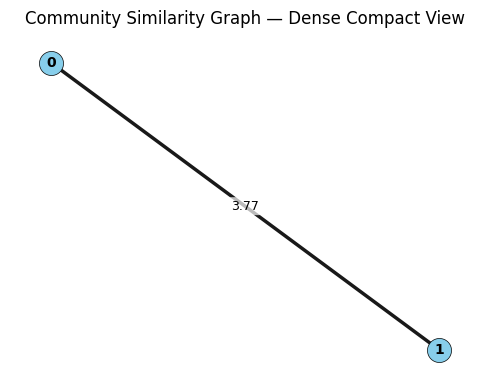

In [59]:
#--------------Table------------------
term_contribs = []

for term, sub in work.groupby("Term", sort=False):
    comms  = sub["Community Index"].to_numpy()
    scores = sub["Overlap (value)"].to_numpy()
    if len(comms) < 2:
        continue
    for i, j in combinations(range(len(comms)), 2):
        u, v = comms[i], comms[j]
        if u > v:
            u, v = v, u
        contrib = comm_similarity_with_term(scores[i], scores[j])
        cat = sub["Category"].iloc[0] if "Category" in sub.columns else None
        term_contribs.append((u, v, term, contrib, cat))

# 2) Build DataFrame
term_df = pd.DataFrame(term_contribs, columns=["u", "v", "Term", "Contribution","Category"])
# 3) Sort and aggregate terms per edge (keep per-term order)
agg_blocks = []
for (u, v), sub in term_df.groupby(["u", "v"]):
    sub_sorted = sub.sort_values("Contribution", ascending=False)
    block = "\n".join(
        [f"  - {t} [{cat}] ({c:.3f})"
        for t, c, cat in zip(sub_sorted["Term"], sub_sorted["Contribution"], sub_sorted["Category"])]
    )
    total = sub_sorted["Contribution"].sum()
    agg_blocks.append({
        "u": u,
        "v": v,
        "Total Weight": total,
        "Terms (by contribution)": block
    })

# 4) Create final block table
block_df = pd.DataFrame(agg_blocks).sort_values("Total Weight", ascending=False).reset_index(drop=True)
block_df.head(30)
# 5) Display nicely
for _, row in block_df.iterrows():
    print(f"Community pair ({row.u}, {row.v}) — Total Weight = {row['Total Weight']:.3f}")
    print(row["Terms (by contribution)"])
    print("-" * 60)

# ========== Visualization ==========

# 1) Remove isolates
non_isolates = [n for n, d in G.degree() if d > 0]
H = G.subgraph(non_isolates).copy()

# 2) Layout for each component (denser)
components = [H.subgraph(c).copy() for c in nx.connected_components(H)]
pos = {}
offset_x = 0.0
gap = 0.8   # smaller gap between components

for comp in components:
    # lower k = shorter edges
    sub_pos = nx.spring_layout(comp, seed=42, k=0.05, iterations=300)
    xs = np.array([p[0] for p in sub_pos.values()])
    ys = np.array([p[1] for p in sub_pos.values()])
    sub_pos = {n: (x - xs.mean() + offset_x, y - ys.mean()) for n, (x, y) in sub_pos.items()}
    pos.update(sub_pos)
    offset_x += (xs.max() - xs.min()) + gap

# 3) Scale edge widths by weight
weights = np.array([H[u][v]['weight'] for u, v in H.edges()], dtype=float)
wmin, wmax = (weights.min(), weights.max()) if len(weights) else (1.0, 1.0)
widths = 2.5 if wmax == wmin else 1.0 + 6.0 * (weights - wmin) / (wmax - wmin)

# 4) Edge labels
edge_labels = {(u, v): f"{H[u][v]['weight']:.2f}" for u, v in H.edges()}

# 5) Draw compact figure
plt.figure(figsize=(5, 4))

nx.draw_networkx_nodes(H, pos, node_size=300, node_color="skyblue",
                       edgecolors="black", linewidths=0.5)
nx.draw_networkx_edges(H, pos, width=widths, alpha=0.9)
nx.draw_networkx_labels(H, pos, font_size=10, font_weight="bold")

nx.draw_networkx_edge_labels(
    H, pos, edge_labels=edge_labels, font_size=9, label_pos=0.5,
    rotate=False, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
)

plt.title("Community Similarity Graph — Dense Compact View", fontsize=12)
plt.axis("off")
plt.tight_layout()
plt.show()

# Robustness Analysis

In [ ]:
def run_enrichment_func(community,term_score_cap,percentage):
    # GO df
    enr_go = gp.enrichr(
        gene_list=community,
        gene_sets=['GO_Biological_Process_2023',
                'GO_Molecular_Function_2023',
                'GO_Cellular_Component_2023'],
        organism='Human',
        outdir=None # don't write to disk
    )
    GO_df = enr_go.results
    mask =  (GO_df["Adjusted P-value"] < term_score_cap) & (GO_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > percentage))
    GO_df = GO_df[mask].copy()   
    
    # KEGG df
    enr_kegg = gp.enrichr(
        gene_list=community,
        gene_sets=['KEGG_2021_Human'],
        organism='Human',
        outdir=None
    )
    KEGG_df = enr_kegg.results
    mask =  (KEGG_df["Adjusted P-value"] < term_score_cap) & (KEGG_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > percentage))
    KEGG_df = KEGG_df[mask].copy() 
       
    # Reactome df
    enr_reactome = gp.enrichr(
        gene_list=community,
        gene_sets=['Reactome_2022'],
        organism='Human',
        outdir=None
    )
    Reactome_df = enr_reactome.results  
    mask =  (Reactome_df["Adjusted P-value"] < term_score_cap) & (Reactome_df["Overlap"].apply(lambda x: int(x.split("/")[0])/int(x.split("/")[1]) > percentage))
    Reactome_df = Reactome_df[mask].copy()
    
    
    all_df = [GO_df,KEGG_df,Reactome_df]
    # build result df by concatenating
    result = pd.concat(all_df, ignore_index=True)
    return result

In [ ]:
from json import JSONDecodeError

# ---------------- 1) Safe wrapper that calls YOUR enrichr function ----------------
_ENR_CACHE = {}  # key: tuple(sorted(genes)) -> DataFrame (copy)

def run_enrichment_safe(run_enrichment_func, community, retries=5, base_sleep=0.8):
    """
    Calls user's run_enrichment_func(community) with retries + memoization.
    Returns a DataFrame (possibly empty). Never raises JSONDecodeError outward.
    """
    # Ensure we always pass a list of gene symbols (never a bare string)
    genes = np.atleast_1d(np.array(community, dtype=object)).tolist()
    if len(genes) == 0:
        return pd.DataFrame()

    key = tuple(sorted(genes))
    if key in _ENR_CACHE:
        return _ENR_CACHE[key].copy()

    for a in range(retries):
        try:
            df = run_enrichment_func(genes,TERM_SCORE_CAP,PERCENTAGE)
            if df is None:
                # treat as transient failure to trigger retry
                raise RuntimeError("run_enrichment_func returned None")
            _ENR_CACHE[key] = df.copy()
            return df
        except (JSONDecodeError, OSError, RuntimeError, ValueError) as e:
            # Transient errors from HTTP/JSON/file handling inside gseapy
            if a == retries - 1:
                # Give up: return empty so pipeline continues
                return pd.DataFrame()
            time.sleep(base_sleep * (2 ** a) + np.random.rand() * 0.3)

    return pd.DataFrame()

# ---------------- 2) Minimal bootstrap to record robust terms ----------------
def get_robust_terms(communities_HGNC, run_enrichment_func,
                     R=50, leaveout=0.10, recurrence_cutoff=0.70, seed=42):
    """
    Uses YOUR run_enrichment_func(community)->DataFrame (already filtered to significant terms).
    Returns DataFrame with columns: community_id, term, recurrence (and Gene_set if available).
    """
    rng = np.random.default_rng(seed)
    rows = []

    for cid, community in enumerate(communities_HGNC):
        n = len(community)
        if n == 0:
            continue
        drop_k = max(1, int(np.floor(leaveout * n)))
        counts = Counter()

        for _ in range(R):
            # Jackknife subset (ensure not empty)
            keep = np.ones(n, dtype=bool)
            keep[rng.choice(n, size=min(drop_k, n), replace=False)] = False
            sub = np.atleast_1d(np.array(community, dtype=object)[keep]).tolist()
            if len(sub) == 0:
                continue

            df = run_enrichment_safe(run_enrichment_func, sub)
            if df is None or df.empty:
                continue

            # Your function already returns significant terms; just count them.
            # If it includes multiple libraries, preserve Gene_set to disambiguate names.
            if 'Term' not in df.columns:
                continue  # be defensive

            if 'Gene_set' in df.columns:
                terms = (df[['Term', 'Gene_set']]
                         .dropna()
                         .drop_duplicates()
                         .apply(lambda r: f"{r['Term']}|{r['Gene_set']}", axis=1)
                         .tolist())
            else:
                terms = df['Term'].dropna().drop_duplicates().tolist()

            counts.update(terms)

            # tiny pause helps with API rate limits if your func calls Enrichr internally
            time.sleep(0.03)

        # Keep only robust terms
        for t, c in counts.items():
            freq = c / max(R, 1)
            if freq >= recurrence_cutoff:
                if '|' in t:
                    term, gene_set = t.split('|', 1)
                    rows.append({'Community Index': cid, 'Term': term, 'recurrence': freq, 'Gene_set': gene_set})
                else:
                    rows.append({'Community Index': cid, 'Term': t, 'recurrence': freq})

    return (pd.DataFrame(rows)
              .sort_values(['Community Index', 'recurrence'], ascending=[True, False])
              .reset_index(drop=True))

In [ ]:
twr3 = get_robust_terms([COMMUNITIES_HGNC[1]], run_enrichment_func,
                                R=25, leaveout=0.1, recurrence_cutoff=0)

In [ ]:
twr3

In [ ]:
terms_with_recurrence = get_robust_terms(COMMUNITIES_HGNC, run_enrichment_func,
                                R=10, leaveout=0.1, recurrence_cutoff=0)

In [ ]:
terms_with_recurrence

In [ ]:
# rename important terms to match terms_with_recurrence
important_terms = important_terms.rename(columns={'index': 'community_id'})
important_terms = important_terms.rename(columns={'Term': 'term'})

In [ ]:
terms_with_rec_merged = important_terms.merge(
    terms_with_recurrence[['community_id', 'term', 'Gene_set', 'recurrence']],
    on=['community_id', 'term', 'Gene_set'],
    how='left'
)

terms_with_rec_merged['recurrence'] = terms_with_rec_merged['recurrence'].fillna(0.0)

terms_with_rec_merged = terms_with_rec_merged.sort_values(
    ['community_id', 'recurrence'],
    ascending=[True, False]
).reset_index(drop=True)

In [ ]:
terms_with_rec_merged

In [ ]:
community_summary = (
    terms_with_rec_merged
    .groupby("community_id")["recurrence"]
    .agg(mean_recurrence="mean", term_count="count")
    .reset_index()
)

print(community_summary)

In [ ]:
display(HTML(terms_with_recurrence.to_html(max_cols=None)))

# Checks!

In [ ]:
c1 = communities_ncbi[2]
DGIDB_genes_ncbi = list(gene_to_index_distinct.keys())
print(c1)
print(DGIDB_genes_ncbi)

['101928687', '8587', '400673', '647215', '347689', '145978', '150590', '120863', '100129075', '113763', '100128292', '140886', '388333', '101927722', '378706', '283033', '119863862', '100506409', '101930370', '474337', '150384', '100874110', '100507495', '152641', '729708', '646996', '391075', '228', '388579', '401630', '83530', '83864', '729682', '109729127', '342892', '2500', '375513', '150381', '150383', '101927151', '8917', '101927809', '56651', '100132911', '340947', '136263', '653639', '143879', '646890', '643744', '100507398', '101927365', '202459', '391123', '285588', '100289017', '105377335', '101929125', '101928076', '642345', '101928324', '161142', '100310846', '100302522', '342125', '64002', '125242', '441212', '100101938', '105374366', '57696', '118568824', '101927992', '7151', '339456', '158055', '92691', '644540', '170958', '541565', '109729172', '113540', '439992', '440173', '128653', '55449', '374470', '317705', '728558', '442240', '146227', '90271', '728927', '56260'

In [154]:
for c in communities_ncbi:
    overlap_count = len(set(c) & set(DGIDB_genes_ncbi))
    print(overlap_count)

0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
